In [ ]:
# Chargement des bibliothèques requis

from __future__ import division
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import gzip
import time
import random
from PIL import Image
from keras import backend as K
from keras.layers import *
from keras.layers import concatenate
from keras.models import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, Callback
from keras import losses
from keras.preprocessing.image import ImageDataGenerator
import scipy.ndimage
#from scipy.misc import imsave
from scipy.ndimage import morphology
from numpy import linalg
from itertools import islice
from scipy.ndimage.morphology import distance_transform_edt as edt

<ipython-input-1-db5df5724fbb>:28: DeprecationWarning: Please use `distance_transform_edt` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import distance_transform_edt as edt


# **Initialisation des différents paramètres**

In [ ]:
# PATH definition
param_path = './params/'
results_path = './results/'
history_path = './history/'

# paths to datasets
path_img = "/content/imgs_train.npy"
path_mask = "/content/imgs_mask_train.npy"


# image dimension (array)
img_rows = 256
img_cols = 256

# data augmentation
fill_mode = 'reflect'
rotation_range= 10
horizontal_flip= True
vertical_flip = True
rescale = 0
zoom_range= 0.2
channel_shift_range = 0.1
width_shift_range = 0.1
height_shift_range = 0.1

# Dropout at test time
#K.set_image_dim_ordering('th')  # Theano dimension ordering in this code
K.set_image_data_format('channels_first')
smooth = 1.
#Dropout.call = call

# training hyperparameters
batch_size = 8
nb_initial_epochs = 100 # number of epochs
steps_per_epoch = 2 # number of steps per epochs
apply_augmentation = False # True or False: Apply Data Augmentation
nb_step_predictions = 10 #5 Number of Monte-Carlo samples to compute the uncertainty

dropout_proba = 0.2 # dropout probability

learning_rate = 1e-2
decay_rate = learning_rate / nb_initial_epochs

apply_edt = True # apply euclidean distance transform when computing the uncertainty
threshold = 0.5 # prediction threshold

nb_active_learning_iter = 8 # number of active learning iteration
active_learning_iter_size = 3#1 # number of patch added during each active learning iteration


# Datasets splitting
init_labelled_size = 150
test_size = 25
validation_size = 50

random_bool = False # True: Baseline (random selection), False: Uncertainty based selection
dont_random = 0 # Number of randomly picked samples among the selected sample (e.g. adding 2 patches:
                #1 selected with uncertainty, 1 picked randomly)

# name to save the results
session_name = "toy_trial"

# number of experiments: multiple experiments should be run to obtain a proper mean and
# standard deviation of the results and overcome randomness of the network.
nb_experiement = 1

# **Traitement et préparation de la base de données**

In [ ]:
# Définition des dossiers contenant les images et les masques
img_folder = '/content/drive/MyDrive/TER/images/'
mask_folder = '/content/drive/MyDrive/TER/masks/'

# Définition des tailles d'images et de masques souhaitées
img_size = (256, 256)
mask_size = (256, 256)

# Lecture des images et des masques
images = []
masks = []
for filename in os.listdir(img_folder):
    if filename.endswith('.jpg'):
        # Lecture de l'image
        img_path = os.path.join(img_folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, img_size)
        images.append(img)

        # Lecture du masque correspondant
        mask_filename = os.path.splitext(filename)[0] + '_label.png'
        mask_path = os.path.join(mask_folder, mask_filename)
        mask = Image.open(mask_path).convert('L')
        #mask = Image.open(mask_path)
        mask = mask.resize(mask_size)
        mask = np.array(mask)
        masks.append(mask)

# Conversion des listes en tableaux numpy
images = np.array(images)
masks = np.array(masks)
print("images shape:", images.shape)
print("images type:", type(images))
print("masks shape:", masks.shape)
print("masks type:", type(masks))
images = images.reshape(images.shape[0], 1, images.shape[1], images.shape[2])
masks = masks.reshape(masks.shape[0], 1, masks.shape[1], masks.shape[2])
print("nouvelle images shape:", images.shape)
print("nouvelle images type:", type(images))
print("nouvelle masks shape:", masks.shape)
print("nouvelle masks type:", type(masks))

images shape: (503, 256, 256)
images type: <class 'numpy.ndarray'>
masks shape: (503, 256, 256)
masks type: <class 'numpy.ndarray'>
nouvelle images shape: (503, 1, 256, 256)
nouvelle images type: <class 'numpy.ndarray'>
nouvelle masks shape: (503, 1, 256, 256)
nouvelle masks type: <class 'numpy.ndarray'>


(503, 1, 256, 256)
(503, 1, 256, 256)


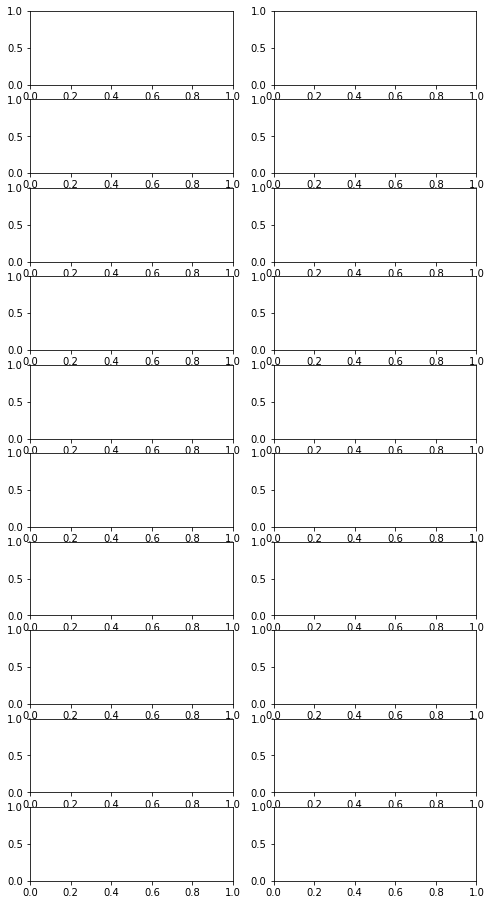

In [ ]:
# Sauvegarde des tableaux numpy dans des fichiers npy
np.save('/content/imgs_train.npy', images)
np.save('/content/imgs_mask_train.npy', masks)

# Lecture des images et des masques à partir des fichiers npy
loaded_images = np.load('/content/imgs_train.npy')
loaded_masks = np.load('/content/imgs_mask_train.npy')
print(loaded_images.shape)
print(loaded_masks.shape)
# Affichage de 10 images et de leurs masques correspondants
fig, axes = plt.subplots(10, 2, figsize=(8, 16))

#for i in range(10):
#    img = loaded_images[i, 0, :, :]
#    mask = loaded_masks[i, 0, :, :]
#    axes[i][0].imshow(img, cmap='gray')
#    axes[i][0].set_title('Image')
#    axes[i][1].imshow(mask, cmap='gray')
#    axes[i][1].set_title('Masque')
#
#plt.tight_layout()
#plt.show()

In [ ]:
print(loaded_images.shape)
print(loaded_masks.shape)

(503, 1, 256, 256)
(503, 1, 256, 256)


# **Chargement des données**

In [ ]:
def preprocessor(input_img, img_rows, img_cols):
    """
    Resize input images to constants sizes
    :param input_img: numpy array of images
    :return: numpy array of preprocessed images
    """
    output_img = np.ndarray((input_img.shape[0], input_img.shape[1], img_rows, img_cols), dtype=np.uint8)

    for i in range(input_img.shape[0]):
        output_img[i, 0] = cv2.resize(input_img[i, 0], (img_cols, img_rows), interpolation=cv2.INTER_CUBIC)

    return output_img

def load_data(path_img, path_mask, img_rows, img_cols):
    """
    Load data from project path
    :return: [X, y] numpy arrays containing the [training, validation, test] data and their respective masks.
    """
    print("\nLoading data...\n")
    X = np.load(path_img)
    y = np.load(path_mask)
    print('shape of X de la fonction load_data:', X.shape)
    print('shape of y de la fonction load_data:', y.shape)

    #X = preprocessor(X, img_rows, img_cols)
    #y = preprocessor(y, img_rows, img_cols)

    X = X.astype('float32')

    mean = np.mean(X)  # mean for data centering
    std = np.std(X)  # std for data normalization

    X -= mean
    X /= std

    y = y.astype('float32')
    y /= 255.  # scale masks to [0, 1]
    return X, y

In [ ]:
g = np.load(path_img)
print(g.shape)


(503, 1, 256, 256)


# **Fonction de perte et d'évaluation**

In [ ]:
#### loss and metrics #####

def dice_coef(y_true, y_pred, smooth=1):
    """Compute Dice Coefficient between prediction and Ground Truth
    :param y_true: ground truth
    :param y_pred: prediction
    :param smooth: avoid division by 0
    :return: dice coefficient
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    """Dice loss to train a network
    :param y_true: ground truth
    :param y_pred: prediction
    :return: dice loss function
    """
    return 1 - dice_coef(y_true, y_pred)


def weighted_binary_crossentropy(y_true, y_pred):
    """Compute the weighted binary cross-entropy
    :param y_true: ground truth
    :param y_pred: prediction
    :return: weighted binary cross-entropy
    """
    b_ce = K.binary_crossentropy(y_true, y_pred)  # Calculate the binary crossentropy
    weight_vector = y_true * 0.30 + (1. - y_true) * 0.70  # Apply the weights
    weighted_b_ce = weight_vector * b_ce
    return K.mean(weighted_b_ce) # Return the mean error


##### data augmentation ######
def data_generator():
    """
    :return: Keras data generator. Data augmentation parameters.
    """
    return ImageDataGenerator(
        fill_mode = fill_mode,
        rotation_range = rotation_range,
        horizontal_flip = horizontal_flip,
        vertical_flip = vertical_flip,
        rescale = rescale,
        zoom_range = zoom_range,
        channel_shift_range = channel_shift_range,
        width_shift_range = width_shift_range,
        height_shift_range = height_shift_range)


##### Monte-Carlo Dropout : keep dropout active at test time #####
def call(self, inputs, training=None):
    """Override Dropout. Make it able at test time
    """
    if 0. < self.rate < 1.:
        noise_shape = self._get_noise_shape(inputs)
        def dropped_inputs():
            return K.dropout(inputs, self.rate, noise_shape,
                             seed=self.seed)
        if (training):
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        else:
            return K.in_test_phase(dropped_inputs, inputs, training=None)
    return inputs


Dropout.call = call


#def reset_weights(model):
#    """Initialize weights of Neural Networks
#    """
#    session = K.get_session()
#    for layer in model.layers:
#        if hasattr(layer, 'kernel_initializer'):
#            layer.kernel.initializer.run(session=session)

def reset_weights(model):
  session = K.get_session()
  for layer in model.layers:
       for v in layer.__dict__:
           v_arg = getattr(layer,v)
           if hasattr(v_arg,'kernel_initializer'):
               initializer_method = getattr(v_arg, 'kernel_initializer')
               initializer_method.run(session=session)
               print('reinitializing layer {}.{}'.format(layer.name, v))


def predict(data, model):
    """
    Data prediction for a given model
    :param data: input data to predict.
    :param model: unet model.
    :return: predictions.
    """
    return model.predict(data, verbose=1)


def save_parameters(timestamp, params):
    """Save current parameters to text file
    :param timestamp:timestamp of the current run session
    :param params: dictionary of current parameters
    """

    if not os.path.exists(param_path):
        os.makedirs(param_path)
        print("Directory " , param_path ,  " Created ")

    param_file = str(param_path + 'params_' + timestamp + '.txt')
    txt_file = open(param_file,'w')
    txt_file.write(str(params))
    txt_file.close()


def get_params():
    """Convert list of current parameters to dictionary
    """
    param_dict = {
    'img_rows':img_rows,
    'img_cols' : img_cols,
    'batch_size' : batch_size,
    'fill_mode' : fill_mode,
    'rotation_range': rotation_range,
    'horizontal_flip': horizontal_flip,
    'vertical_flip' : vertical_flip,
    'rescale' : rescale,
    'zoom_range': zoom_range,
    'channel_shift_range' : channel_shift_range,
    'width_shift_range' : width_shift_range,
    'height_shift_range' : height_shift_range,
    'nb_initial_epochs' : nb_initial_epochs,
    'apply_augmentation' : apply_augmentation,
    'nb_step_predictions': nb_step_predictions,
    'steps_per_epoch' : steps_per_epoch,
    'learning_rate' : learning_rate,
    'decay_rate' : decay_rate,
    'apply_edt' : apply_edt
    }
    return param_dict


def save_history(history, timestamp, iteration, history_path):
    """ Save training history in text file
    :param history: training history (numpy array)
    :param timestamp: timestamp of current run session
    :param iteration: active learning iteration number
    :param history_path: path to history text file
    """
    history_file = str(history_path + timestamp + '_history_iter_' +  str(iteration) +'_' + '.txt')
    txt_file = open(history_file,'w')
    txt_file.write(str(history))
    txt_file.close()


def create_paths():
    """
    Creates all the output paths.
    """
    path_history = "/content/history/"
    path_results = "/content/results/"
    path_models = "/content/models/"

    if not os.path.exists(path_history):
        os.makedirs(path_history)
        print("Path created: ", path_history)

    if not os.path.exists(path_results):
        os.makedirs(path_results)
        print("Path created: ", path_results)

    if not os.path.exists(path_models):
        os.makedirs(path_models)
        print("Path created: ", path_models)

if __name__ == '__main__':
    create_paths()

Path created:  /content/history/
Path created:  /content/results/
Path created:  /content/models/


# **Architecture UNET**

In [ ]:
def unet_full_bn(dropout):
    inputs = Input((1, img_rows, img_cols))
    conv1 = Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    conv1 = Conv2D(32, (3, 3), padding="same", activation="relu")(conv1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(batch1)
    pool1 = Dropout(dropout_proba)(pool1)


    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(pool1)
    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(conv2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(batch2)
    pool2 = Dropout(dropout_proba)(pool2)


    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(pool2)
    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(conv3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(batch3)
    pool3 = Dropout(dropout_proba)(pool3)

    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu")(pool3)
    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu")(conv4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(batch4)

    if dropout:
        pool4 = Dropout(dropout_proba)(pool4)

    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu")(pool4)
    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu")(conv5)

    if dropout:
        conv5 = Dropout(dropout_proba)(conv5)

    up6_interm = UpSampling2D(size=(2, 2))(conv5)

    up6 = concatenate([up6_interm, conv4], axis=1)

    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu")(up6)
    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu")(conv6)
    batch6 = BatchNormalization(axis=1)(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=1)

    if dropout:
        up7 = Dropout(dropout_proba)(up7)

    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu")(up7)
    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu")(conv7)
    batch7 = BatchNormalization(axis=1)(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(batch7), conv2], axis=1)
    up8 = Dropout(dropout_proba)(up8)

    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu")(up8)
    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu")(conv8)
    batch8 = BatchNormalization(axis=1)(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(batch8), conv1], axis=1)
    up9 = Dropout(dropout_proba)(up9)

    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu")(up9)
    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu")(conv9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation="sigmoid")(batch9)

    model = Model(outputs=conv10, inputs=inputs)

    model.compile(optimizer=Adam(lr = learning_rate, decay=decay_rate), loss= dice_coef_loss,
                  metrics = [dice_coef])
    model.summary()

    return model

# **Fonctions de mesure de scores**

In [ ]:
## Score measure

def numeric_score(y_pred, y_true):
    """Compute True Positive, True Negative, False Positive, False Negative classifications
    between a prediction and its ground truth
    :param y_pred: prediction
    :param y_true: ground truth
    :return: True Positive, True Negative, False Positive, False Negative
    """
    y_pred = y_pred.astype(int)
    y_true = y_true.astype(int)
    FP = float(np.sum((y_pred == 1) & (y_true == 0)))
    FN = float(np.sum((y_pred == 0) & (y_true == 1)))
    TP = float(np.sum((y_pred == 1) & (y_true == 1)))
    TN = float(np.sum((y_pred == 0) & (y_true == 0)))
    return FP, FN, TP, TN


def jaccard_score(y_pred, y_true):
    """Compute Jaccard Score (= Intersection / Union) between a prediction and its ground truth
    :param y_pred: prediction
    :param y_true: ground truth
    :return: Jaccard score value
    """
    intersection = (y_pred * y_true).sum()
    union = y_pred.sum() + y_true.sum() - intersection
    if union == 0:
        return 1.
    else:
        return float(intersection)/union


def pixel_wise_accuracy(y_true, y_pred):
    """Compute Pixel-wise accuracy (= number of well classified pixel / total number of pixel)
    between a prediction and its ground truth
    :param y_pred: prediction
    :param y_true: ground truth
    :return: Pixel-wise accuracy value
    """
    y_true_f = y_true.reshape([1, img_rows * img_cols])
    y_pred_f = y_pred.reshape([1, img_rows * img_cols])
    return 1 - np.count_nonzero(y_pred_f - y_true_f) / y_true_f.shape[1]


def precision_score(y_pred, y_true):
    """Compute precision (= TP / (TP+FP)) between a prediction and its ground truth
    :param y_pred: prediction
    :param y_true: ground truth
    :return: Precision score value
    """
    FP, FN, TP, TN = numeric_score(y_pred, y_true)
    if (TP + FP) <= 0:
        return 0.
    else:
        return np.divide(TP, TP + FP)


def sensitivity_score(y_pred, y_true):
    """Compute sensitivity (= TP / (TP+FN)) between a prediction and its ground truth
    :param y_pred: prediction
    :param y_true: ground truth
    :return: Sensitivity score value
    """
    FP, FN, TP, TN = numeric_score(y_pred, y_true)
    if (TP + FN) <= 0:
        return 0.
    else:
        return np.divide(TP, TP + FN)

# **Mesure de l'incertitude**

In [ ]:
# normalisation de plage (range normalization) pour un échantillon donné, Le résultat est un tableau numpy normalisé avec
# une plage de valeurs entre 0 et 255.
def range_transform(sample):
    """
    Range normalization for 255 range of values
    :param sample: numpy array for normalize
    :return: normalize numpy array
    """
    if (np.max(sample) == 1):
        sample = sample * 255

    m = 255 / (np.max(sample) - np.min(sample))
    n = 255 - m * np.max(sample)
    return (m * sample + n) / 255

#La fonction retourne le coefficient Dice pour évaluer la similarité entre le masque de vérité terrain et le masque de prédiction.
def compute_dice_coef(y_true, y_pred):
    """
    Computes the Dice-Coefficient of a prediction given its ground truth.
    :param y_true: Ground truth.
    :param y_pred: Prediction.
    :return: Dice-Coefficient value.
    """
    smooth = 1.  # pour éviter les divisions par zéro en cas de valeurs nulles dans les tableau
    # les tableaux y_true et y_pred sont transformés (flatten) en un vecteur 1D pour pouvoir effectuer des opérations vectorielles.
    y_true_f = y_true.reshape([1, img_rows * img_cols])
    y_pred_f = y_pred.reshape([1, img_rows * img_cols])
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def compute_uncertain(sample, model):
    """
    Computes uncertainty map for a given sample and its prediction for a given model, based on the
    number of step predictions defined in constants file.
    :param sample: input sample.
    :param model: unet model with Dropout layers.
    :return: averaged-thresholded predictions after nb_steps_prediction samples
    :return: overall uncertainty (not map)
    :return: uncertainty_map.
    """
    X = np.zeros([1, img_rows, img_cols])
    # nb_step_predictions: le nombre de prédictions à effectuer pour l'échantillon donné.
    # model : le modèle de segmentation d'image à utiliser pour la prédiction.
    for t in range(nb_step_predictions):
        prediction = model.predict(sample, verbose=1).reshape([1, img_rows, img_cols])
        X = np.concatenate((X, prediction))

    # On supprime la première ligne de la matrice X (remplie de zéros) pour obtenir une matrice de taille [nb_step_predictions, img_rows, img_cols] contenant les prédictions du modèle pour chaque itération.
    X = np.delete(X, [0], 0)
    # averaged-thresholded predictions after np_step_prediction predicted samples
    # calcule une prédiction moyenne à partir de la matrice X en prenant la moyenne des prédictions pour chaque pixel, et on applique
    # un seuil pour obtenir une prédiction binaire.
    # X_prediction : la prédiction binaire résultante.
    X_prediction = cv2.threshold(np.mean(X, axis=0), threshold, 1, cv2.THRESH_BINARY)[1].astype('uint8')

    # on applique une normalisation par transformée de distance à la variance de la matrice X, en utilisant la fonction edt
    # pour calculer la transformée de distance.
    if (apply_edt):
        # apply distance transform normalization.
        var = np.var(X, axis=0)
        transform = range_transform(edt(1 - prediction))
        # La fonction retourne la prédiction binaire, la somme de la multiplication entre la variance et la transformée de distance, et la multiplication entre la variance et la transformée de distance.
        return X_prediction, np.sum(np.multiply(var, transform)),  np.multiply(var, transform)

    else:
        # retourne la prédiction binaire, la somme de la racine carrée de la variance de la matrice X, et la variance de la matrice X.
        return X_prediction, np.sum(np.sqrt(np.var(X, axis=0))), np.var(X, axis=0)


def compute_uncertain_map(sample, prediction, model):
    """
    Computes uncertainty map for a given sample and its prediction for a given model, based on the
    number of step predictions defined in constants file.
    :param sample: input sample.
    :param prediction: input sample prediction.
    :param model: unet model with Dropout layers.
    :return: uncertainty map.
    """
    X = np.zeros([1, img_rows, img_cols])

    for t in range(nb_step_predictions):
        prediction = model.predict(sample, verbose=1).reshape([1, img_rows, img_cols])
        X = np.concatenate((X, prediction))

    X = np.delete(X, [0], 0)

    if (apply_edt):
        # apply distance transform normalization.
        var = np.var(X, axis=0)
        transform = range_transform(edt(prediction))
        return var * transform

    else:
        return np.var(X, axis=0)

# **L'apprentissage actif**

In [ ]:
#La fonction concatène l'échantillon nouvellement annoté correspondant à l'index "added_index" dans le tableau "added" avec l'ensemble
#de données initialement étiqueté "original" à l'aide de la fonction "vstack" de numpy. En d'autres termes, la fonction ajoute l'échantillon
#nouvellement annoté au tableau d'entraînement existant pour augmenter la taille de l'ensemble de données d'entraînement.

def add_annotated_sample(original, added, added_index):
    """append the annotated samples to the training set
    "original" est un tableau numpy représentant l'ensemble de données initialement étiqueté et utilisé pour entraîner un modèle d'apprentissage automatique.
    "added" est également un tableau numpy, représentant un ensemble de données supplémentaires qui ont été étiquetés par un humain dans le cadre de l'apprentissage actif pour la segmentation.
    "added_index" est un entier indiquant l'indice de l'échantillon ajouté dans le tableau "added".
    """
    return np.vstack((original, added[added_index] ))

# Cette fonction est utile pour la mise en place d'un processus d'apprentissage actif pour la segmentation, où l'ensemble de données initial est
# divisé en ensembles d'entraînement, de validation et de test, ainsi qu'en un ensemble d'échantillons non étiquetés qui seront étiquetés
# au fur et à mesure du processus d'apprentissage actif
def data_splitting(X_set, training_size, validation_size, test_size):
    """generate indexes to split initial dataset in train, validation and test sets
    :param X_set: initial dataset (all the samples)
    :param training_size: size of the training set
    :param validation_size: size of the validation set
    :param test_size: size of the test set
    :return: indexes for labelled, unlabelled, test and validation sets
    """
    #calcule la taille de l'ensemble de données non étiqueté en soustrayant la taille des ensembles d'entraînement, de validation et de test de la taille de l'ensemble de données initial.
    unlabelled_size = len(X_set) - training_size - validation_size - test_size
    # "index_labelled" contient les indices des échantillons utilisés pour l'entraînement
    index_labelled = np.arange(0, training_size, 1)
    # "index_unlabelled" contient les indices des échantillons non étiquetés
    index_unlabelled = np.arange(training_size, training_size + unlabelled_size, 1)
    # "index_test" contient les indices des échantillons utilisés pour le test
    index_test = np.arange(training_size + unlabelled_size, training_size + unlabelled_size + test_size, 1)
    # "index_validation" contient les indices des échantillons utilisés pour la validation
    index_validation = np.arange(training_size + unlabelled_size + test_size, len(X_set), 1)
    return index_labelled, index_unlabelled, index_test, index_validation


def split_for_simulation(X, y, index_labelled, index_unlabelled, index_test, index_validation):
    """split initial dataset in train, validation and test sets based on indexes
    """
    # X_labelled_0 et y_labelled_0 : données et labels pour l'ensemble d'apprentissage étiqueté initial.
    X_labelled_0 = X[index_labelled]
    y_labelled_0 = y[index_labelled]

    # X_unlabelled_0 et y_unlabelled_0 : données et labels pour l'ensemble d'apprentissage non-étiqueté initial.
    X_unlabelled_0 = X[index_unlabelled]
    y_unlabelled_0 = y[index_unlabelled]

    #X_test et y_test : données et labels pour l'ensemble de test.
    X_test = X[index_test]
    y_test = y[index_test]

    #X_validation et y_validation : données et labels pour l'ensemble de validation.
    X_validation = X[index_validation]
    y_validation = y[index_validation]

    return X_labelled_0, y_labelled_0, X_unlabelled_0, y_unlabelled_0, X_test, y_test, X_validation, y_validation

In [ ]:
def scores(model, X_test, y_test, score_global):
    """Compute predictions scores on test set for the current active learning iteration
    :param model: trained Unet model
    :param X_test: test set
    :param y_test: test ground truth
    :param score global: numpy array with previous scores
    :return: numpy array with scores
    """
    uncertain_map = []
    uncertain = np.zeros(len(X_test))
    dice = np.zeros(len(X_test))
    jaccard = np.zeros(len(X_test))
    accuracy = np.zeros(len(X_test))
    sensitivity = np.zeros(len(X_test))
    precision = np.zeros(len(X_test))

    print("Computing predictions on test data ...\n")
    predictions = predict(X_test, model)

    for i in range(len(X_test)):
        sample = X_test[i].reshape([1, 1, img_rows, img_cols])
        sample_prediction = cv2.threshold(predictions[i], threshold, 1, cv2.THRESH_BINARY)[1].astype('uint8')
        dice[i] = compute_dice_coef(y_test[i][0], sample_prediction)
        jaccard[i] = jaccard_score(sample_prediction, y_test[i][0, :, :])
        accuracy[i] = pixel_wise_accuracy(sample_prediction, y_test[i][0, :, :])
        sensitivity[i] = sensitivity_score(sample_prediction, y_test[i][0, :, :])
        precision[i] = precision_score(sample_prediction, y_test[i][0, :, :])
        _ , uncertain[i], uncertain_map_i = compute_uncertain(sample, model)
        #uncertain_map_i = compute_uncertain_map(sample, sample_prediction, model)
        uncertain_map.append(uncertain_map_i)

    uncertain_map_array = np.asarray(uncertain_map)
    print("Done computing predictions on test data")
    metrics_array = np.array([np.mean(dice), np.mean(jaccard), np.mean(accuracy), np.mean(precision),
                                np.mean(sensitivity)])
    score_global = np.vstack((score_global, metrics_array))
    return score_global


def balance_uncertainty(sample_pred, uncertainty, apply_edt):
    """Multiply uncertainty by a ratio to overcome unbalanced class issues
    :param sample_pred: prediction for a sample
    :param uncertainty: associated uncertainty measure
    :return: scaled uncertainty measure
    """
    if apply_edt == True:
        ratio = 1
    else:
        ratio = (1.0 / ((np.count_nonzero(sample_pred) + 1.0) / (512*512* 1.0)))
    return uncertainty * ratio


def uncertainty_for_ranking(model, X_set):
    """Compute uncertainty and uncertainty map for a set of images
    :param model: trained Unet model
    :param X_set: set of data
    :return: numpy array with uncertainty value and numpy array of uncertainty maps for each image of X_set,
    and final prediction for X_set, which is an AVERAGE OF THE nb_step_prediction FORWARD PASS PREDICTIONS
    """
    # uncertainty computation for unlabelled
    print("Computing predictions for unlabelled data ...\n")
    uncertain_map = []
    uncertainty = np.zeros(len(X_set))
    predictions = predict(X_set, model)
    X = []
    for i in range(len(X_set)):
        sample = X_set[i].reshape([1, 1, img_rows, img_cols])
        sample_prediction = cv2.threshold(predictions[i], threshold, 1, cv2.THRESH_BINARY)[1].astype('uint8')
        X_i, uncertainty_i, uncertain_map_i = compute_uncertain(sample, model)
        uncertainty[i] = balance_uncertainty(X_i, uncertainty_i, apply_edt) # scale uncertainty
        uncertain_map.append(uncertain_map_i)
        X.append(X_i)
    uncertain_map_array = np.asarray(uncertain_map)
    return uncertainty, uncertain_map, X



# La fonction sélectionne les échantillons les plus incertains à partir de la liste des échantillons non étiquetés (uncertain_unlabelled) et
# renvoie une liste des indices des échantillons sélectionnés (index) après chaque itération d'apprentissage actif.
def to_be_added_index(active_learning_iter_size, index, uncertain_unlabelled, dont_random):
    """ Select the most uncertain samples, retrieve its indice in order to add it to the training set
    :param active_learning_iter_size: number of samples selected to be added to the training set after each AL iteration
    :param index: list of already selected unlabelled samples
    :param uncertain_unlabelled: Uncertainty measures for all unlabelled samples
    :param dont_random: number of randomly selected samples to be added to the training set (< active_learning_iter_size)
    :return: list of selected samples indices after each AL iteration
    """
    uncert_unlab = np.copy(uncertain_unlabelled)
    if dont_random == 0:
        for m in range(active_learning_iter_size):
            to_be_added = np.argmax(uncert_unlab)
            while to_be_added in index:
                uncert_unlab[to_be_added] = 0
                to_be_added = np.argmax(uncert_unlab)
            index.append(to_be_added)
        return index
    else:
        for m in range(active_learning_iter_size - dont_random):
            to_be_added = np.argmax(uncertain_unlabelled)
            while to_be_added in index:
                uncertain_unlabelled[to_be_added] = 0
                to_be_added = np.argmax(uncertain_unlabelled)
            index = np.append(np.asarray(index), np.asarray(to_be_added))
        left_to_pick = np.setdiff1d(np.arange(len(uncertain_unlabelled)), np.asarray(index))
        random_index = np.random.choice(left_to_pick, dont_random, replace=False)
        return np.hstack((np.asarray(index, dtype = int), np.asarray(random_index, dtype = int)))


# Cette fonction to_be_added_random permet de sélectionner des échantillons au hasard à ajouter à l'ensemble de données d'entraînement.
def to_be_added_random(active_learning_iter_size, index, uncertain_unlabelled):
    """ Select randomly samples to add to the training set (baseline)
    :param active_learning_iter_size: number of samples selected to be added to the training set after each AL iteration
    :param index: list of already selected unlabelled samples
    :param uncertain_unlabelled: Uncertainty measures for all unlabelled samples
    :return: list of selected samples indices after each AL iteration
    """
    lim = 0
    for m in range(active_learning_iter_size):
        to_be_added = random.randint(0, len(uncertain_unlabelled) -1)
        while to_be_added in index:
            if lim > 100:
                to_be_added = np.delete[np.arange(len(uncertain_unlabelled), index)[0]]
            to_be_added = random.randint(0, len(uncertain_unlabelled)-1)
            lim = lim + 1
        index.append(to_be_added)
    return index

def save_results(result, name, session_name, random_bool):
    if random_bool == True:
        np.save(str(results_path + name + session_name + "_random" ), result)
    else:
        np.save(str(results_path + name + session_name), result)

# **Lancement de l'apprentissage**

In [ ]:
# load data
X_full, y_full = load_data(path_img, path_mask, img_rows, img_cols )


# data_splitting
# l'ensemble de données initial est divisé en ensembles d'entraînement, de validation et de test, ainsi qu'en un ensemble d'échantillons
# non étiquetés qui seront étiquetés au fur et à mesure du processus d'apprentissage actif
index_labelled, index_unlabelled, index_test, index_validation = data_splitting(X_full, init_labelled_size,
                                                                                validation_size, test_size)


print('len index_labelled',len(index_labelled))
print('len index_unlabelled',len(index_unlabelled))
print('len index_test',len(index_test))
print('len index_validation',len(index_validation))



# split data into train (labelled, 30%), unlabelled (active learning simulation, 50%), test (20%)
X_labelled_0, y_labelled_0, X_unlabelled_0, y_unlabelled_0, X_test, y_test , X_validation, y_validation = split_for_simulation(
                                                                                                X_full,
                                                                                                y_full,
                                                                                                index_labelled,
                                                                                                index_unlabelled,
                                                                                                index_test,
                                                                                                index_validation)
print('shape X_labelled_0',X_labelled_0.shape)
print('shape X_unlabelled_0',X_unlabelled_0.shape)
print('shape X_test',X_test.shape)
print('shape X_validation',X_validation.shape)
print('visualisation des X_labelled_0:')
print('-----------------------------------------------------------------------------------------------------------------')
score_average = []
indexes_experiments = []

for r in range(nb_experiement):
    print("\n\n*****************EXPERIMENT " + str(r+1) + " IS STARTING********************")

    rank_iter = np.zeros((nb_active_learning_iter, len(index_unlabelled)))
    uncertain_iter = np.zeros((nb_active_learning_iter, len(index_unlabelled)))

    # full experience
    uncertainty_unlabelled = np.zeros((nb_active_learning_iter, len(index_unlabelled)))
    to_be_annotated_index = []

    print("X_labelled shape = ", X_labelled_0.shape, "X_unlabelled shape = ", X_unlabelled_0.shape)
    print("X_test shape = ", X_test.shape,"X_validation shape = ", X_validation.shape )
    print("------------DATA SPLITTING DONE---------\n")

    timestamp = format(time.strftime('%m%d_%H%M_%S'))
    print("TIMESTAMP:", timestamp)


    # START ACTIVE LEARNING ITERATION
    for i in range(nb_active_learning_iter):

        if random_bool == True:
            model_path = "./models/AL_model_random_" + str(i) + ".hdf5"
            print(model_path)
        else:
            model_path = "./models/AL_model_test_" + str(i) + ".hdf5"     # save trained model after each training
            print(model_path)

        print("\n---------Starting AL Iteration number " + str(i) + '----------')

        if i == 0: #initialization
            X_labelled = X_labelled_0
            y_labelled = y_labelled_0
            X_unlabelled = X_unlabelled_0
            y_unlabelled = y_unlabelled_0
            score_global = np.zeros(5)
        else:
            # select the samples that are going to be annotated by expert
            uncertain_iter[i] = uncertain_unlabelled
            if random_bool == True:
                to_be_annotated_index = to_be_added_random(active_learning_iter_size, to_be_annotated_index,
                                                           uncertain_unlabelled)
            else:
                to_be_annotated_index = to_be_added_index(active_learning_iter_size, to_be_annotated_index,
                                                          uncertain_unlabelled, dont_random)


            print("List of samples to be annotated by oracle=",  to_be_annotated_index)
            # add this samples + masks to the train set
            X_labelled = add_annotated_sample(X_labelled_0, X_unlabelled_0, to_be_annotated_index)
            y_labelled = add_annotated_sample(y_labelled_0, y_unlabelled_0, to_be_annotated_index)


            print("new X_labelled shape = ", X_labelled.shape, "new y_labelled shape =", y_labelled.shape)
            print("new X_unlabelled shape=", X_unlabelled.shape, "new y_unlabelled shape =", y_unlabelled.shape)


        ## Retrain with new dataset

        # data augmentation
        seed = 1
        train_img_generator = data_generator().flow(X_labelled, seed = seed, batch_size = batch_size,  shuffle=False)
        train_mask_generator = data_generator().flow(y_labelled, seed = seed, batch_size = batch_size, shuffle=False)
        train_generator = zip(train_img_generator, train_mask_generator)


        # load model
        model = unet_full_bn(dropout = True)
        weights = model.get_weights()

        # retrain from scratch after each iteration
        reset_weights(model)


        print("------------TRAINING -----------")
        save_parameters(timestamp, get_params()) # save parameters
        tensorboard = TensorBoard(log_dir = str("../logs2/" + str(timestamp)) + "_iter_" + str(i), write_images=True) # tensorboard
        #print(train_generator.shape)
        print(X_validation.shape)
        print(y_validation.shape)
        history = model.fit(train_generator,
                                        validation_data = (X_validation, y_validation),
                                        epochs = nb_initial_epochs,
                                        verbose = 2,
                                        shuffle = True,
                                        steps_per_epoch = steps_per_epoch,
                                        callbacks = [tensorboard])

        save_history(history.history, timestamp, i, history_path) # save training history
        model.save(model_path) # save fully trained model

        save_results(uncertain_iter, "uncertainty_iter_", session_name, random_bool)

        print("----------- Training done --------------")

        print("\n----------- RANKING -----------")
        # compute predictions / uncertainty for ranking on unlabelled dataset
        uncertain_unlabelled, uncertain_map, unlabelled_prediction = uncertainty_for_ranking(model, X_unlabelled)
        save_results(uncertain_map, "uncertainty_map_x_unlabelled_", session_name, random_bool)


        print("------------Computing scores on test set -----------")
        # score computation on X_test
        score_global = scores(model, X_test, y_test, score_global)
        save_results(score_global, "score_global_", session_name, random_bool)

    # save score global on test set for each experiment
    score_average.append(score_global)
    save_results(score_average, "score_average_", session_name, random_bool)


    # track selected samples over experiments
    indexes_experiments.append(to_be_annotated_index)
    print("Selected samples over experiments=", indexes_experiments)
    save_results(indexes_experiments, "index_uncert_", session_name, random_bool)


Loading data...

shape of X de la fonction load_data: (503, 1, 256, 256)
shape of y de la fonction load_data: (503, 1, 256, 256)
len index_labelled 150
len index_unlabelled 278
len index_test 25
len index_validation 50
shape X_labelled_0 (150, 1, 256, 256)
shape X_unlabelled_0 (278, 1, 256, 256)
shape X_test (25, 1, 256, 256)
shape X_validation (50, 1, 256, 256)
visualisation des X_labelled_0:
-----------------------------------------------------------------------------------------------------------------


*****************EXPERIMENT 1 IS STARTING********************
X_labelled shape =  (150, 1, 256, 256) X_unlabelled shape =  (278, 1, 256, 256)
X_test shape =  (25, 1, 256, 256) X_validation shape =  (50, 1, 256, 256)
------------DATA SPLITTING DONE---------

TIMESTAMP: 0326_1336_38
./models/AL_model_test_0.hdf5

---------Starting AL Iteration number 0----------
Model: "model"
__________________________________________________________________________________________________
 Layer (t

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
1/1 [==============================] - 0s 37ms/step
------------Computing scores on test set -----------
Computing predictions on test data ...

1/1 [==============================] - 0s 32ms/step
Done computing predictions on test data
./models/AL_model_test_7.hdf5

---------Starting AL Iteration number 7----------
List of samples to be annotated by oracle= [224, 233, 100, 3, 247, 186, 176, 205, 106, 15, 67, 66, 214, 92, 246, 212, 251, 22, 90, 187, 256]
new X_labelled shape =  (171, 1, 256, 256) new y_labelled shape = (171, 1, 256, 256)
new X_unlabelled shape= (278, 1, 256, 256) new y_unlabelled shape = (278, 1, 256, 256)
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 1, 256, 256  0           []         

# **Les résultats**

**Score Dice sur l'ensemble de test, comparé à la ligne de base aléatoire**

In [ ]:
score_average_random = np.load(results_path + "score_average_"+ session_name + ".npy")
score_average_uncert = np.load(results_path + "score_average_" + session_name + ".npy")

mean_uncert = np.mean(score_average_uncert, axis = 0)
mean_rand = np.mean(score_average_random, axis = 0)

std_uncert= np.std(score_average_uncert, axis = 0)
std_rand = np.std(score_average_random, axis = 0)

print("Random Baseline array (Mean and Std) shapes: ", mean_rand.shape, std_rand.shape)
print("Uncertainty method array (Mean and Std) shapes: ", score_average_uncert.shape, score_average_random.shape)

Random Baseline array (Mean and Std) shapes:  (9, 5) (9, 5)
Uncertainty method array (Mean and Std) shapes:  (1, 9, 5) (1, 9, 5)


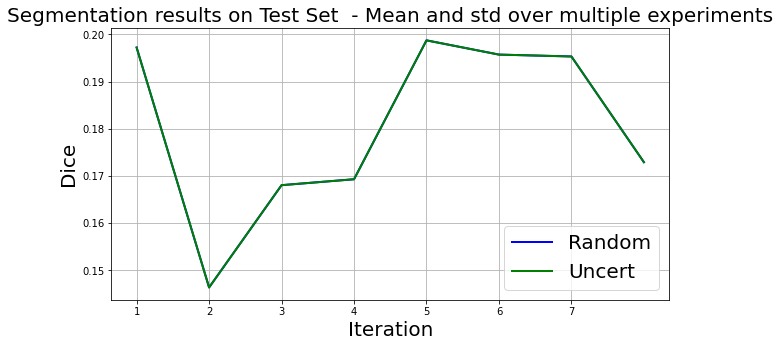

In [ ]:
mu_rand = mean_rand[1:, 0]
sigma_rand = std_rand[1:, 0]

mu_uncert = mean_uncert[1:, 0]
sigma_uncert = std_uncert[1:, 0]

fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(range(1, len(mu_rand)+1), mu_rand, lw=2, label='Random', color='blue')
ax.plot(range(1, len(mu_uncert)+1), mu_uncert, lw=2, label='Uncert', color='green')
ax.fill_between(range(1, len(mu_rand)+1), mu_rand+sigma_rand, mu_rand-sigma_rand, facecolor='blue', alpha=0.1)
ax.fill_between(range(1, len(mu_uncert)+1),mu_uncert+sigma_uncert, mu_uncert-sigma_uncert, facecolor='green', alpha=0.1)
ax.set_title('Segmentation results on Test Set  - Mean and std over multiple experiments', fontsize = 20)
ax.legend(loc='lower right', fontsize = 20)
ax.set_xlabel('Iteration', fontsize = 20)
ax.set_ylabel('Dice', fontsize = 20)
ax.set_xticks(range(1, len(mu_uncert)))
ax.grid()

**Résultats de la segmentation sur l'ensemble de test pour les 3 PLUS INCERTAINS**

In [ ]:
#Les 3 échantillons les plus incertains de l'ensemble de test
uncertain_test, uncertain_map_test, predictions_test = uncertainty_for_ranking(model, X_test)
predictions_test = np.asarray(predictions_test)
print("Top 3 most uncertain samples in test set: " , np.argsort(uncertain_test)[-5:])

Computing predictions for unlabelled data ...

1/1 [==============================] - 0s 25ms/step
Top 3 most uncertain samples in test set:  [13 19 11 14 18]


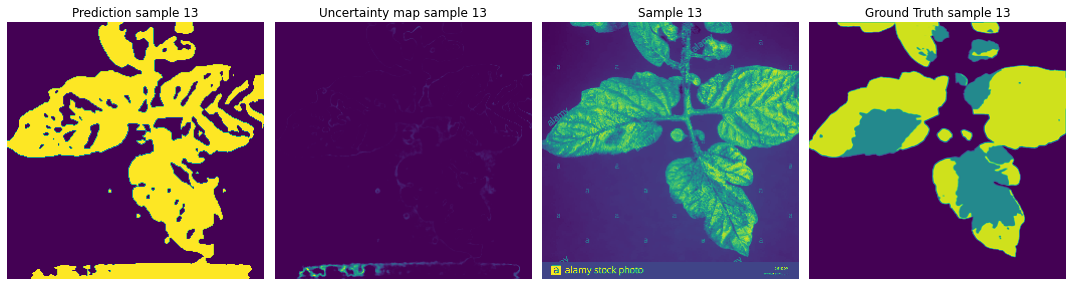

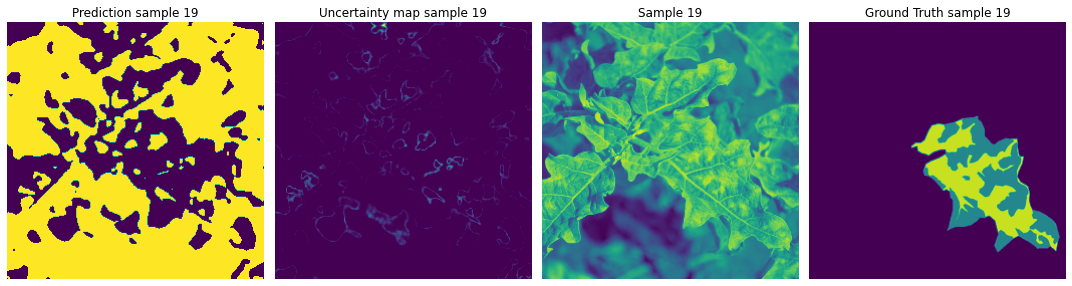

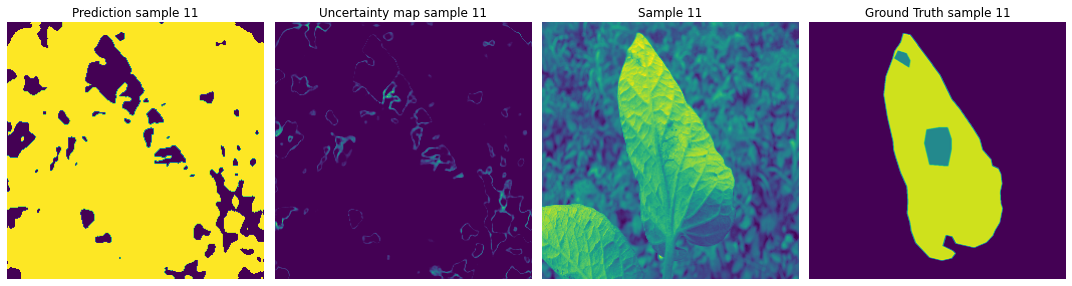

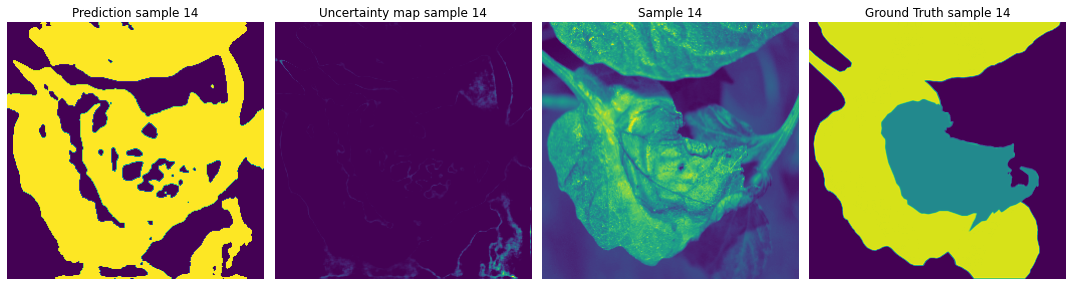

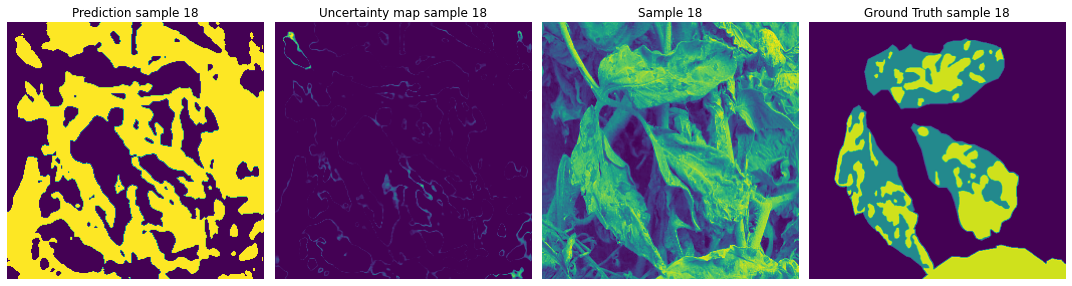

In [ ]:
for indice in np.argsort(uncertain_test)[-5:]:
    plt.figure(figsize=(15,15))
    plt.subplot(141)
    plt.axis('off')
    plt.imshow(predictions_test[indice][:,:])
    plt.title("Prediction sample " + str(indice))
    plt.subplot(142)
    plt.axis('off')
    plt.imshow(np.asarray(uncertain_map_test)[indice, 0])
    plt.title("Uncertainty map sample "+ str(indice))
    plt.subplot(143)
    plt.axis('off')
    plt.imshow(X_test[indice][0,:,:])
    plt.title("Sample "+ str(indice))
    plt.subplot(144)
    plt.axis('off')
    plt.imshow(y_test[indice][0,:,:])
    plt.title("Ground Truth sample "+ str(indice))
    plt.tight_layout()
    plt.show()

**Résultats de la segmentation sur l'ensemble de test à une itération spécifique**

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 1, 256, 256  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_152 (Conv2D)            (None, 32, 256, 256  320         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_153 (Conv2D)            (None, 32, 256, 256  9248        ['conv2d_152[0][0]']             
                                )                                                           

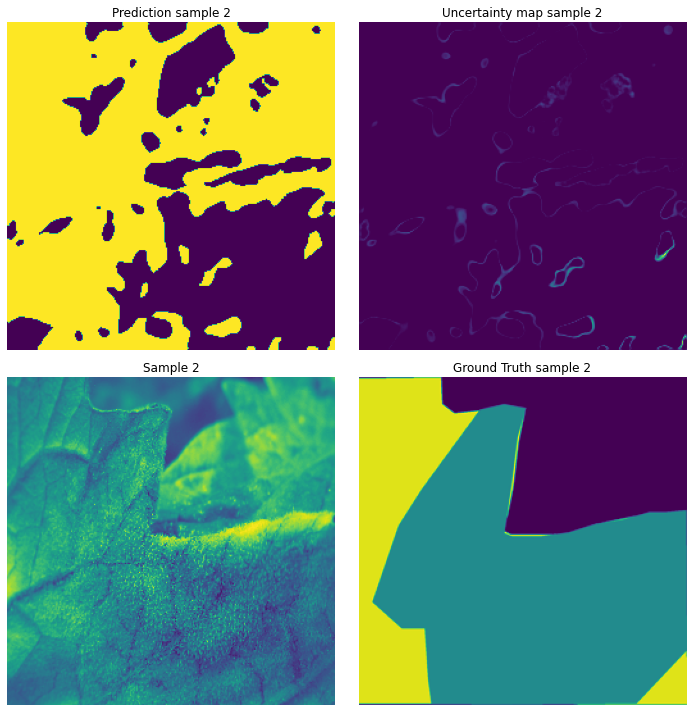

In [ ]:
model_iter = unet_full_bn(dropout = True)
# load weights of your model at a certain iteration
model_iter.load_weights('./models/AL_model_test_4.hdf5')
uncertain_test, uncertain_map_test, predictions_test = uncertainty_for_ranking(model_iter, X_test)
predictions_test = np.asarray(predictions_test)
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(predictions_test[2][:,:])
plt.title("Prediction sample " + str(2))
plt.axis('off')
plt.subplot(222)
plt.imshow(np.asarray(uncertain_map_test)[2, 0])
plt.title("Uncertainty map sample "+ str(2))
plt.axis('off')
plt.subplot(223)
plt.imshow(X_test[2][0,:,:])
plt.title("Sample "+ str(2))
plt.axis('off')
plt.subplot(224)
plt.imshow(y_test[2][0,:,:])
plt.title("Ground Truth sample "+ str(2))
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Index analysis
indexes = np.load("/content/results/index_uncert_toy_trial.npy")
print(indexes.shape)
indexes

(1, 21)


array([[224, 233, 100,   3, 247, 186, 176, 205, 106,  15,  67,  66, 214,
         92, 246, 212, 251,  22,  90, 187, 256]])

In [ ]:
X_unlabelled_0.shape

(278, 1, 256, 256)

In [ ]:
for i in indexes[1]:
    plt.imshow(X_unlabelled_0[i, 0, :, :])
    plt.show()

IndexError: ignored

In [ ]:
heat = np.zeros((72, 72))
for i in range(indexes.shape[1]):
    unique, counts = np.unique(indexes[:, i], return_counts=True)
    col = dict(zip(unique, counts))
    for j in range(indexes.shape[1]):
        if j in unique:
            heat[j, i] =  col[j]
        else:
            heat[j, i] = 0

print(heat)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


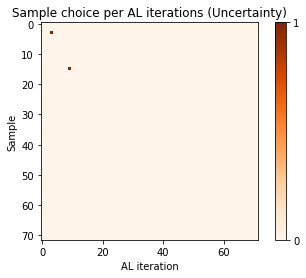

In [ ]:
plt.imshow(heat, cmap='Oranges')
# plt.legend(cmap)
plt.xlabel("AL iteration")
# plt.xticks(range(8))
plt.ylabel("Sample")
plt.title("Sample choice per AL iterations (Uncertainty)")
# plt.legend(range(14), loc = 'best')
plt.colorbar(ticks=[0,  1, 2, 3])
plt.show()

In [ ]:
def plot_iteration_analysis(nb_active_learning_iter, score_global, width, ylim_active):
    n_groups = 5
    width = width
    fig, ax = plt.subplots(figsize = (20, 10))
    index = np.arange(n_groups)

    for i in np.arange(1, nb_active_learning_iter, 1):
        plot = np.arange(-0.5, 3.8, width)
        color = "C" + str(i)
        color = np.arange(0.05, 1, 0.05)
        color = ['black','grey', 'orange', 'red', 'pink']
        rects1 = plt.bar(index + plot[i], score_global[i], width=width, color = color, label=i)


    plt.ylabel('Values',fontsize=20)
    plt.title('Pixelwise segmentation metrics ',fontsize=20)
    plt.xticks(index, ('Dice', 'Jaccard', 'Accuracy', 'Precision', 'Sensitivity'),fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid(True)
    if ylim_active == True:
        plt.ylim(0.5, 1)

    plt.tight_layout()
    plt.show()

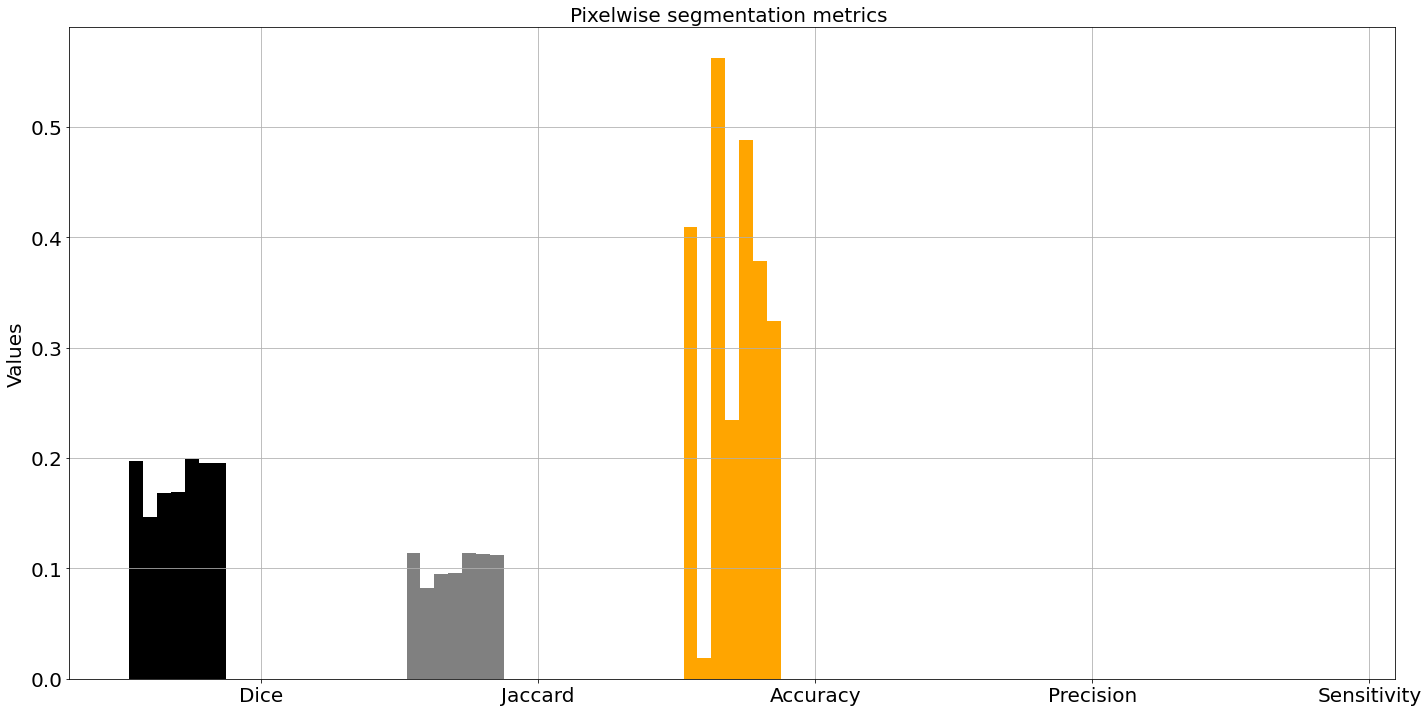

In [ ]:
plot_iteration_analysis(nb_active_learning_iter, score_global, width = 0.05 , ylim_active =False )

In [ ]:
def read_history(history_path):
    txt_file = open(history_path,'r')
    text = txt_file.read()[2:-1].split(", '")

    loss = np.fromstring(text[0].split("[")[1][:-1], sep=',')
    val_dice_coef = np.fromstring(text[1].split("[")[1][:-1], sep=',')
    val_loss = np.fromstring(text[2].split("[")[1][:-1], sep=',')
    dice_coef = np.fromstring(text[3].split("[")[1][:-1], sep=',')
    return loss, val_dice_coef, val_loss, dice_coef

<ipython-input-31-ffb713fb4fbc>:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(420 + 2*i + 1)


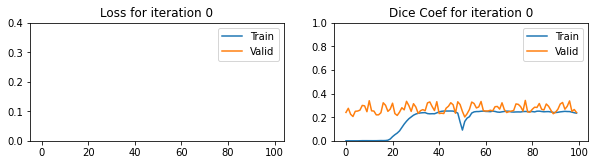

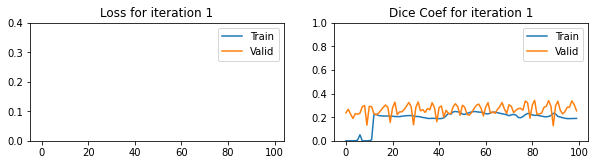

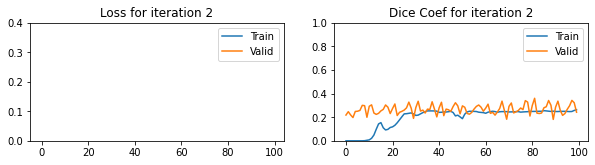

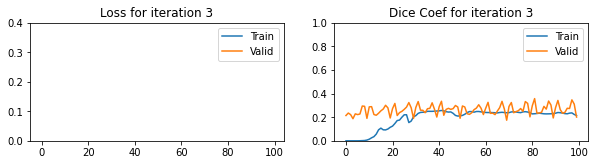

In [ ]:
for i  in range(4):
    history_path = ['/content/history/0326_1336_38_history_iter_0_.txt',
                    "/content/history/0326_1336_38_history_iter_1_.txt",
                    "/content/history/0326_1336_38_history_iter_2_.txt",
                   "/content/history/0326_1336_38_history_iter_3_.txt",
                    "/content/history/0326_1336_38_history_iter_7_.txt"]
    loss, val_dice_coef, val_loss, dice_coef = read_history(history_path[i])
    fig, ax = plt.subplots(figsize = (10, 10))
    plt.subplot(420 + 2*i + 1)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title("Loss for iteration " + str(i))
    plt.legend(["Train", "Valid"])
    plt.ylim(0, 0.4)
    plt.subplot(420 + 2*i + 2)
    plt.plot(dice_coef)
    plt.plot(val_dice_coef)
    plt.title("Dice Coef for iteration " + str(i))
    plt.legend(["Train", "Valid"])
    plt.ylim(0, 1)
    plt.show()